In [15]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.filter import matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
import numpy as np
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
import pandas as pd
from pycbc.filter import sigma
import h5py
from pycbc.types import timeseries
from pycbc.types import TimeSeries

In [16]:
def psd_data(conditioned):

    from pycbc.psd import interpolate, inverse_spectrum_truncation
    # Estimate the power spectral density

    # We use 4 second samples of our time series in Welch method.
    psd = conditioned.psd(4)

    # Now that we have the psd we need to interpolate it to match our data
    # and then limit the filter length of 1 / PSD. After this, we can
    # directly use this PSD to filter the data in a controlled manner

    psd = interpolate(psd, conditioned.delta_f)

    # 1/PSD will now act as a filter with an effective length of 4 seconds
    # Since the data has been highpassed above 30 Hz, and will have low values
    # below this we need to informat the function to not include frequencies
    # below this frequency. 
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=30)

#     pp.loglog(psd.sample_frequencies, psd)
#     pp.ylabel('$Strain^2 / Hz$')
#     pp.xlabel('Frequency (Hz)')
#     pp.xlim(30, 1024)
    
    return psd

In [17]:
def gen_SNR(template,conditioned,psd):
    

    snr = matched_filter(template, conditioned,
                         psd=psd, low_frequency_cutoff=30)

    # The `matched_filter` function actually returns a 'complex' SNR.
    # What that means is that the real portion correponds to the SNR
    # associated with directly filtering the template with the data.
    # The imaginary portion corresponds to filtering with a template that
    # is 90 degrees out of phase. Since the phase of a signal may be 
    # anything, we choose to maximize over the phase of the signal.

    peak = abs(snr).numpy().argmax()
    snrp = abs(snr[peak])
    snrp_compl = snr[peak]
    time = snr.sample_times[peak]

    return snr,time,peak,snrp,snrp_compl

In [18]:
def gen_chisquare(temp,data,m_1,m_2,s_1,s_2,psd):

    n =int(0.72*pycbc.pnutils.get_freq('fSEOBNRv4Peak',m_1,m_2,s_1,s_2)**0.7)

    chisq = power_chisq(temp, data, n, psd=psd, low_frequency_cutoff=30.0)

    # convert to a reduced chisq
    chisq /= (n * 2) - 2

    return chisq

In [19]:
def snr_chisq_nsnr(num_templates,data_templates,psd,data,s):

    template_info = []

    for i in range(num_templates):
        T1 = data_templates[i]

        S1,time_peak,index_peak_bns,old_snr_bns,snrp_compl = gen_SNR(T1,data,psd)
        S1.save(f"Signals_BBH_BNS/snr_complete_series/snr{i}.hdf")

        chisq_1 = gen_chisquare(T1,data,temp_bank[i][0],temp_bank[i][1],s,s,psd)
        chisq_val_bns = chisq_1[index_peak_bns]

        new_snr = newsnr(abs(S1),chisq_1)
        nsnr = TimeSeries(np.array(new_snr),delta_t = S1.delta_t)
        nsnr_peak = nsnr.numpy().argmax()
        nsnr_snrp = nsnr[nsnr_peak]
        nsnrp_time = nsnr.sample_times[nsnr_peak]
        
        print(i)
        pp.plot(S1.sample_times,abs(S1),'-.',label='snr')
        pp.plot(nsnr.sample_times,nsnr,zorder=10,label='newsnr')
        pp.show()
        

        template_info.append([temp_bank[i][0],temp_bank[i][1], nsnrp_time,old_snr_bns,nsnr_snrp,chisq_val_bns,i,snrp_compl])

    return template_info

In [20]:
def recovery(data,n,data_templates,psd): 

    full__info =  snr_chisq_nsnr(n,data_templates,psd,data,0.)

    info = {}
    for i in  full__info:
        print(i)
        info.update({i[4] : [i[0],i[1],i[2],i[3],i[5],i[6],i[7]]})

    snrp_1 = max(info.keys())
    time_1 = info.get(snrp_1 )[2]
    m1_1 = info.get(snrp_1 )[0]
    m2_1 = info.get(snrp_1 )[1]
    chi_sq_1 = info.get(snrp_1 )[4]
    index = info.get(snrp_1 )[5]
    snrp_compl = info.get(snrp_1 )[6]

    print("The signal detected is due to the following masses ",m1_1,"M and ", m2_1, "M at time ", time_1, "seconds", " with new SNR value as", snrp_1, " and chi~square value as ", chi_sq_1,"at index",index)

    return m1_1,m2_1,time_1,snrp_1,full__info,index,snrp_compl

In [21]:
def aligned_template(mass_1, mass_2, time, snrp_compl, ts1,index):
    dt = time - ts1.start_time
    temp_sub  = data_templates[index]

    aligned = temp_sub.cyclic_time_shift(dt)

    aligned = (aligned.to_frequencyseries() * snrp_compl).to_timeseries() / abs(snrp_compl)
    aligned.start_time = ts1.start_time

    return aligned

In [45]:
def find_signal(index,aligned_temp):
     
       
        T_B1_MF = timeseries.load_timeseries(f"Signals_BBH_BNS/snr_complete_series/snr{index}.hdf")

        A = []
        B = []
        C = []
        maxim_SNR = []
        
        



        for i in range(12):
            if i != index:
                cross = matched_filter(data_templates[i],aligned_temp ,
                                 psd=psd1, low_frequency_cutoff=30)
#                 C.append(cross)
#                 print(i)
#                 pp.plot(ts1.sample_times,ts1)
#                 pp.plot(cross.sample_times,cross)
#                 pp.show()

                T_N1_MF = timeseries.load_timeseries(f"Signals_BBH_BNS/snr_complete_series/snr{i}.hdf")

                A_B1 = (T_B1_MF - (cross*T_N1_MF))/(1-(cross**2))
                A.append(A_B1)

                A_N1 = (T_N1_MF - (cross*T_B1_MF))/(1-(cross**2))
                B.append(A_N1) 

                norm = (A_B1**2) + (A_N1**2) + 2*(A_B1*A_N1*cross)

                SNR = ((A_B1*T_B1_MF) + ( A_N1 * T_N1_MF))/norm

                peak_SNR = abs(SNR).numpy().argmax()

                SNR_p = abs(SNR[peak_SNR])

                maxim_SNR.append([i,SNR_p,T_N1_MF[peak_SNR]])

        M_SNR = 0
        idx = 0
        cSNR = 0

        for i in range(len(maxim_SNR)):
            if M_SNR < maxim_SNR[i][1]:
                M_SNR = maxim_SNR[i][1]
                idx = maxim_SNR[i][0]
                cSNR = maxim_SNR[i][2]
                
#         C[idx].plot()
                
    

        return idx, M_SNR, temp_bank[idx][0], temp_bank[idx][1], SNR.sample_times[idx], cSNR

   
        


In [23]:
data_templates = []

for i in range(6):
    T = timeseries.load_timeseries(f"Signals_BBH_BNS/signal_bbh{i}.hdf")
    data_templates.append(T)
for i in range(6):
    R = timeseries.load_timeseries(f"Signals_BBH_BNS/signal_bns{i}.hdf")
    data_templates.append(R)
    
temp_bank = pd.read_csv('Signals_BBH_BNS/Load_bbh_bns.csv')
temp_bank = temp_bank.values.tolist()

Recovery number: 0
 
0


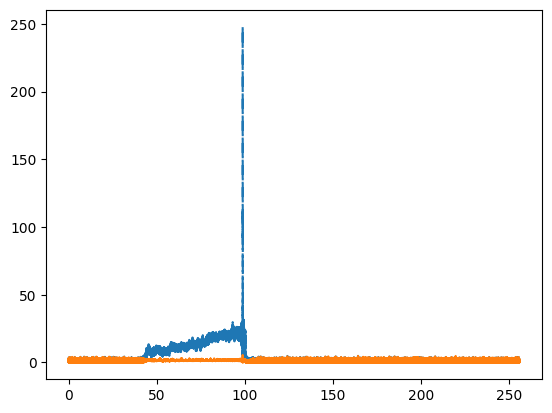

1


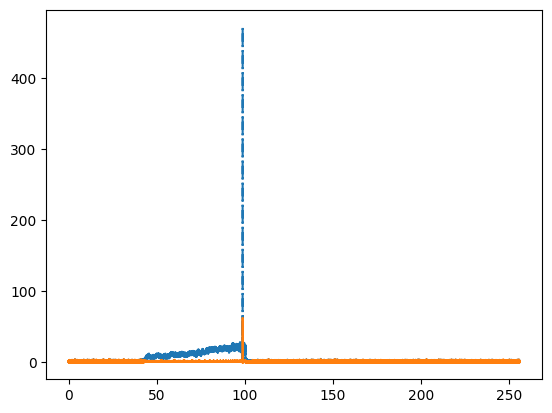

2


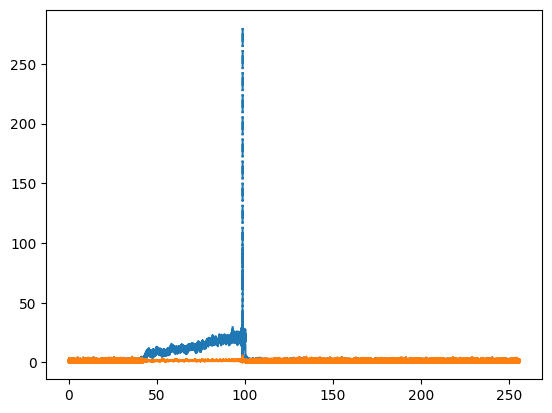

3


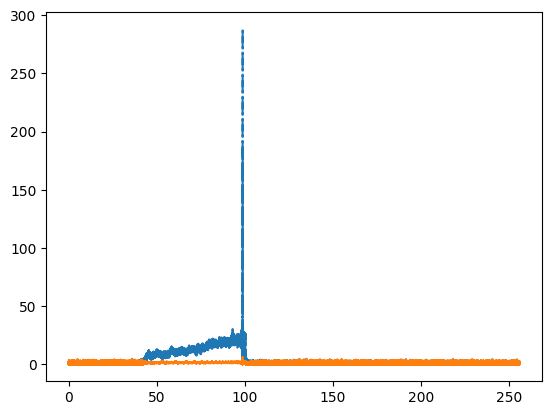

4


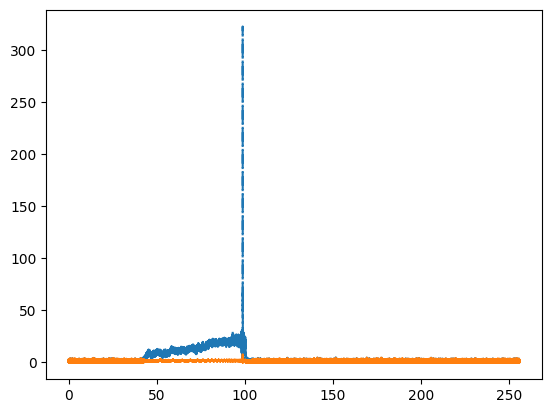

5


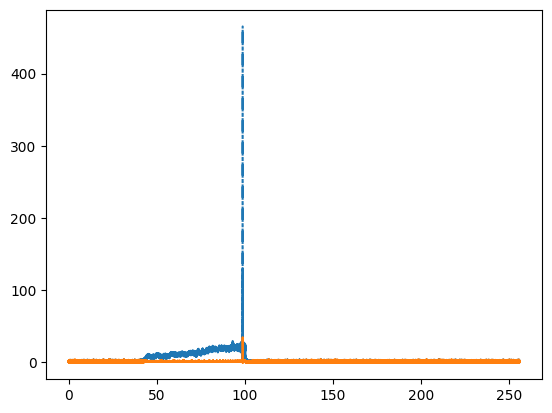

6


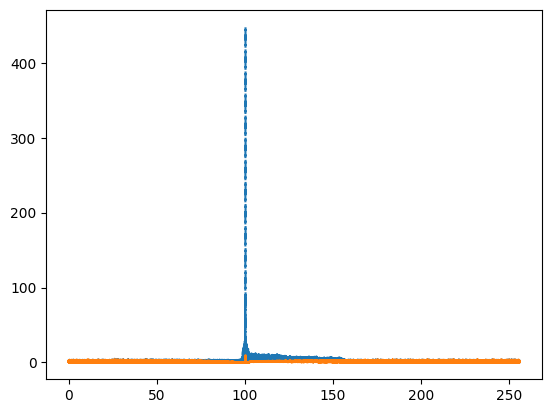

7


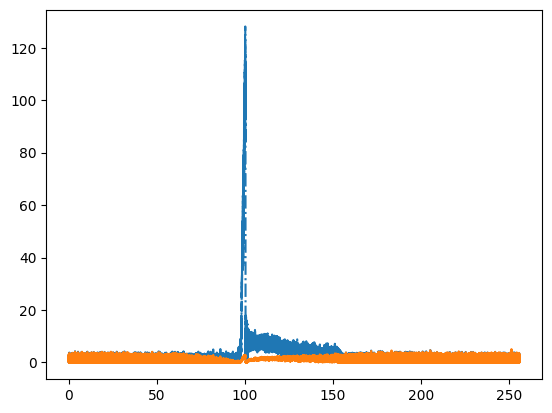

8


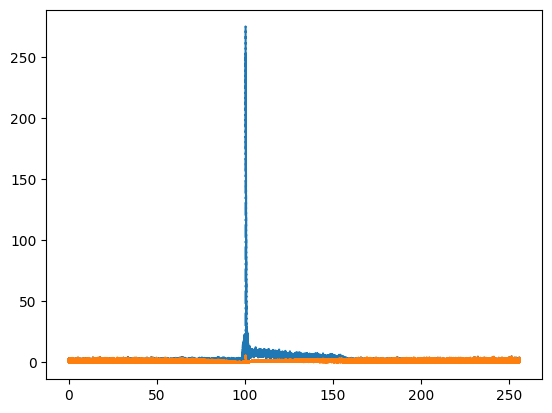

9


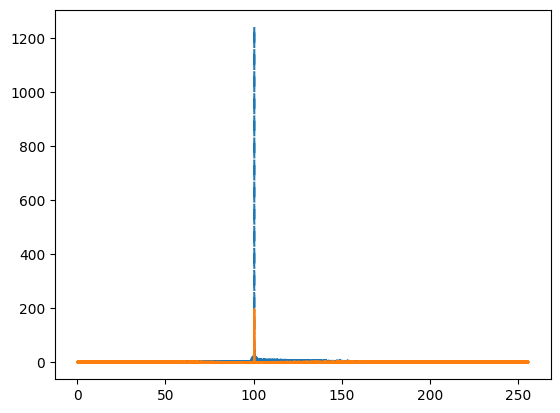

10


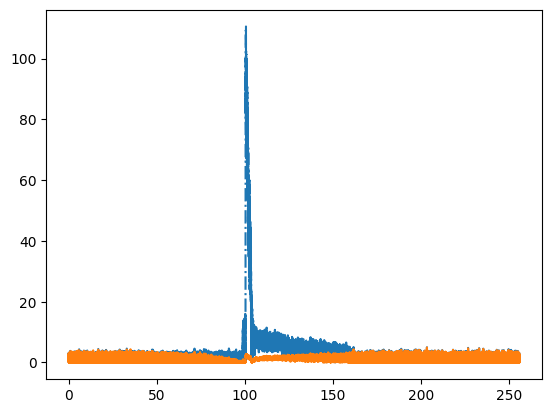

11


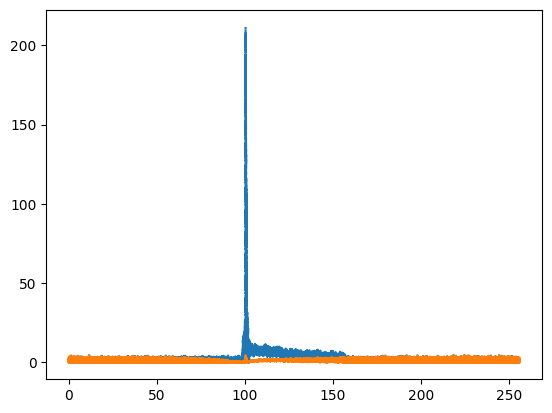

[16.068172572798268, 29.18234154110653, 98.80078125, 248.04485692600102, 5.5447111775875, 2521.424262282579, 0, (234.7429591775527-80.13734562615694j)]
[23.963197990653477, 26.059224598128225, 98.7998046875, 472.97844974106295, 62.79203048485624, 71.48527442378726, 1, (472.7126253488141+15.855212243643118j)]
[22.426518667622208, 34.54525965399993, 98.797607421875, 281.27725943197515, 5.962285572053902, 2804.0582365765285, 2, (3.6698121473327796+281.25331847351765j)]
[29.054320393740284, 26.92588046272803, 98.798095703125, 288.4562423553438, 6.433207691151559, 2533.075126867629, 3, (-276.2393619107185-83.05912764364872j)]
[15.309060121092957, 33.74002868828148, 98.80029296875, 322.90124021200165, 7.829048223110485, 2143.210467915127, 4, (-261.9185577692024+188.84882850192582j)]
[20.0, 30.0, 98.7998046875, 465.23945939378314, 34.97186248235231, 222.97638988317252, 5, (242.3529435422116-397.1307156761426j)]
[1.3367036366089622, 1.3854251491263936, 100.4111328125, 448.4857569335956, 9.8007

In [24]:
for j in range(1):

    print("Recovery number:",j)
    print(' ')

    ts1 = timeseries.load_timeseries(f"Signals_BBH_BNS/Data_{j}.hdf")
    psd1 = psd_data(ts1)
    mass_1,mass_2,time,snrp,total,index_trigger,snrp_compl = recovery(ts1,12,data_templates,psd1)

    print(' ')

In [26]:
 mass_1,mass_2,time,snrp,index_trigger,snrp_compl

(1.2785395505632264,
 1.444743830067412,
 100.427490234375,
 197.77945476324163,
 9,
 (1240.6497416411314+90.89753698447454j))

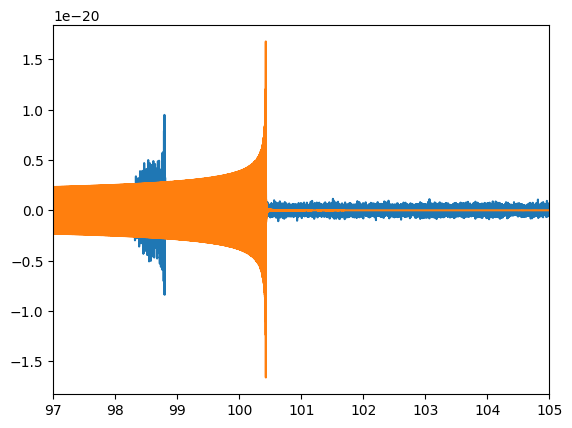

In [29]:
aligned_temp = aligned_template(mass_1, mass_2, time, snrp_compl, ts1,index_trigger)
pp.plot(ts1.sample_times,ts1)
pp.plot(aligned_temp.sample_times,aligned_temp)
pp.xlim(97,105)
pp.show()


0


/home/kajolshelke/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


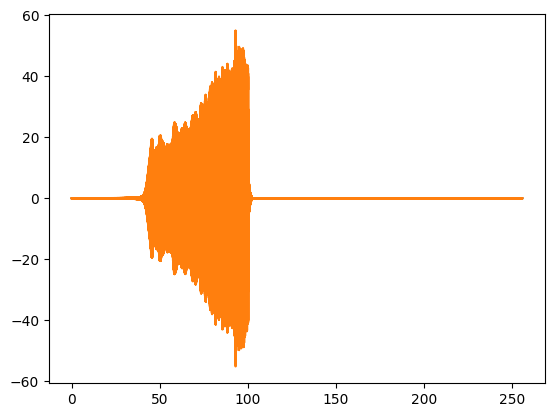

1


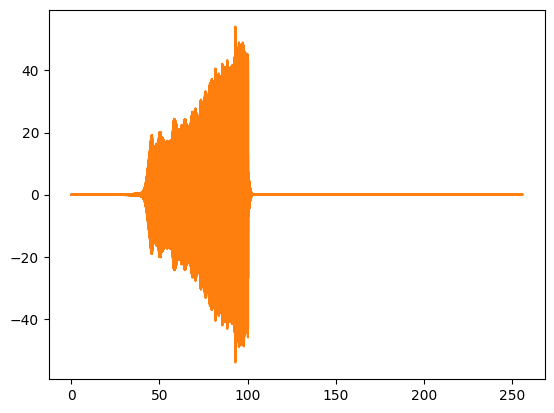

2


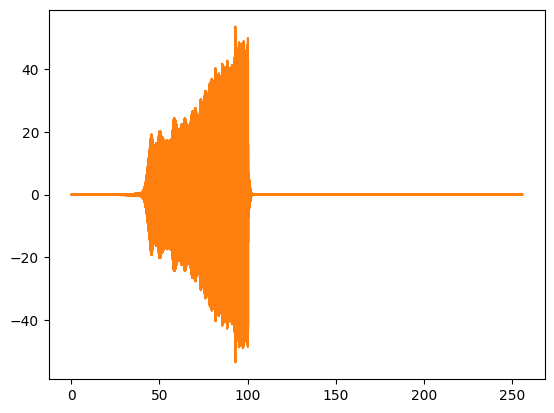

3


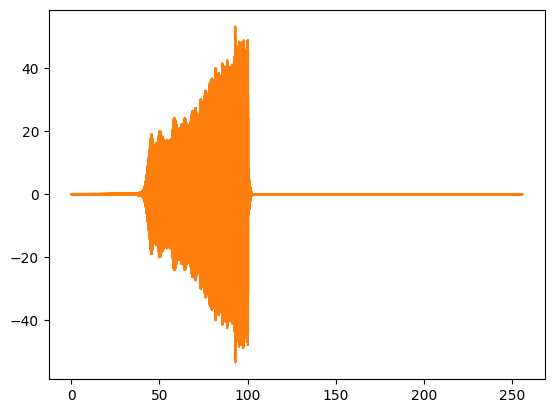

4


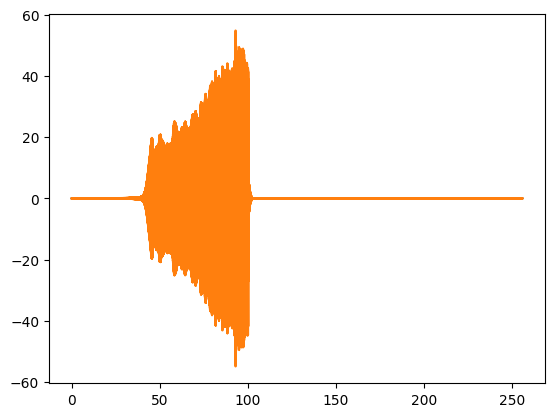

5


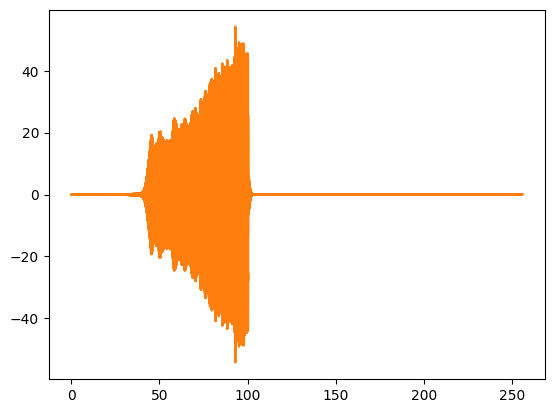

6


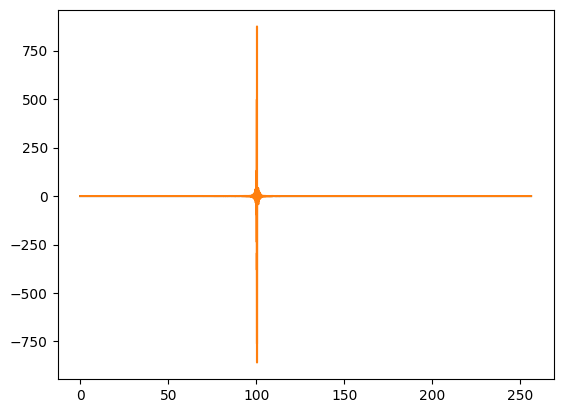

7


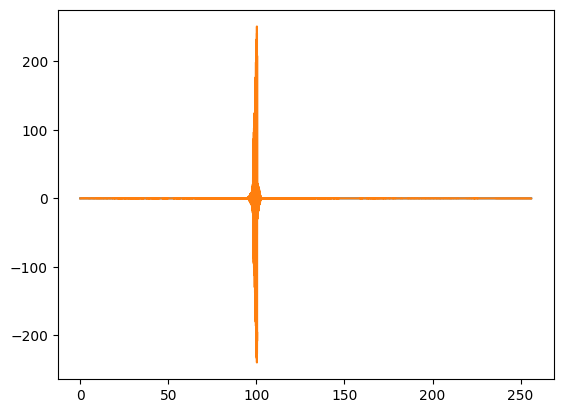

8


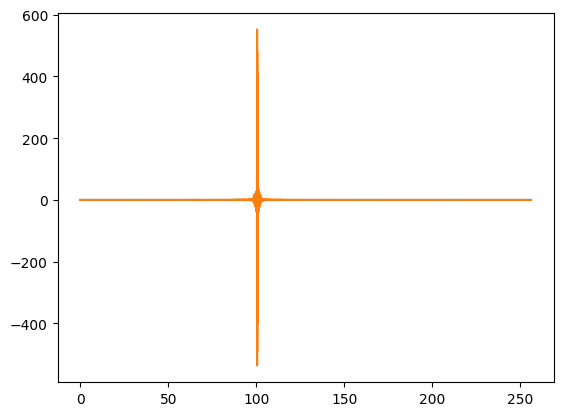

10


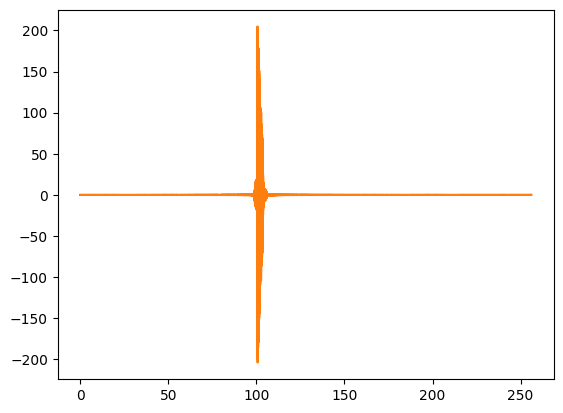

11


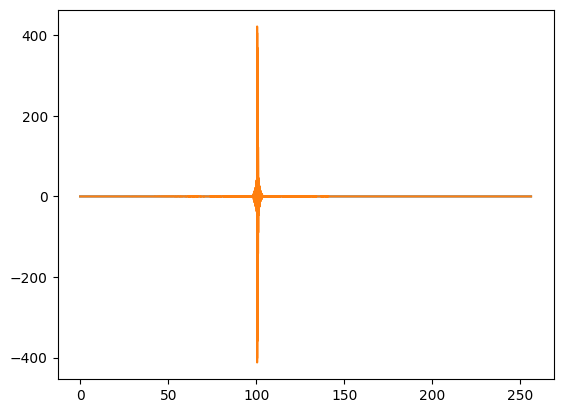

3 [29.054320393740284, 26.92588046272803] 1.0000000000008291


In [30]:
index = index_trigger
i_new,snrp_signal,M1, M2, T, Complex_SNRP = find_signal(index,aligned_temp)
print(i_new,temp_bank[i_new],snrp_signal)


In [14]:
i_new,snrp_signal,M1, M2, T, Complex_SNRP

(3,
 1.0000000000008291,
 29.054320393740284,
 26.92588046272803,
 0.000732421875,
 (-0.7561233413035153-0.7426722162508181j))

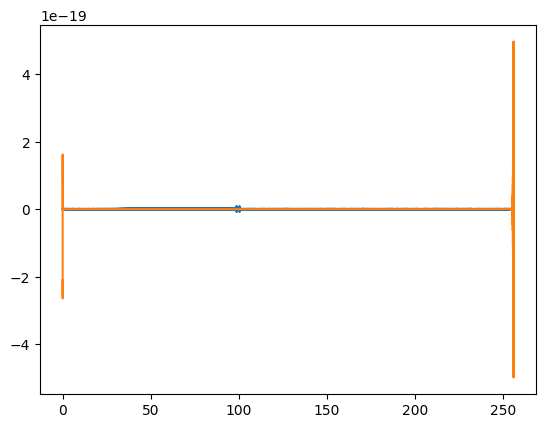

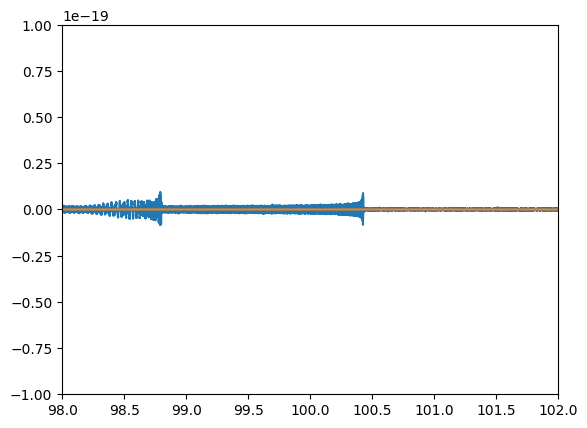

In [43]:
aligned_temp = aligned_template(M1, M2, T, Complex_SNRP, ts1,i_new)
pp.plot(ts1.sample_times,ts1)
pp.plot(aligned_temp.sample_times,aligned_temp)
pp.show()


pp.plot(ts1.sample_times,ts1)
pp.plot(aligned_temp.sample_times,aligned_temp)
pp.xlim(98,102)
pp.ylim(-1*(10**-19),1*(10**-19))
pp.show()




In [46]:
index = i_new
i_new,snrp_signal,M1, M2, T, Complex_SNRP = find_signal(index,aligned_temp)
print(i_new,temp_bank[i_new],snrp_signal)

0 [16.068172572798268, 29.18234154110653] 1.0000000000001326
